# 如何建立线性因子模型

算法交易策略使用线性因子模型来量化资产回报与代表这些回报主要驱动因素的风险来源之间的关系。每个因素风险都有溢价，总资产回报预计对应于这些风险溢价的加权平均值。


从构建和资产选择到风险管理和绩效评估，因子模型在整个投资组合管理过程中有多种实际应用。随着常见风险因素现在可以交易，因素模型的重要性持续增长：

- 通过更少数量的因素对许多资产的回报进行汇总，减少了优化投资组合时估计协方差矩阵所需的数据量
- 对资产或投资组合对这些因素的暴露程度的估计可以管理由此产生的风险，例如在风险因素本身进行交易时输入适当的对冲
- 因子模型还允许评估新 alpha 因子的增量信号内容
- 因子模型还可以帮助评估管理者相对于基准的绩效是否确实归因于选择资产和把握市场时机的技能，或者是否可以通过投资组合对已知回报驱动因素的倾斜来解释绩效，而这些回报驱动因素现在可以复制作为低成本、被动管理的基金，无需支付主动管理费


## 导入和设置

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

## 获取数据

Fama 和 French 通过他们的[网站](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)提供更新的风险因素和研究组合数据，您可以使用`pandas_datareader ` 包来获取数据。

### 风险因子

特别是，我们将使用五个 Fama-French 因子，这些因子首先将股票分为三个规模组，然后针对其余三个公司特定因子中的每个因子将其分为两个规模组。

因此，这些因素涉及三组价值加权投资组合，按规模和账面市值比、规模和运营盈利能力以及规模和投资形成 3 x 2 类。风险因子值计算为投资组合的平均回报 (PF)，如下表所示：


| 标签 | 名称                          | 描述                                                                                                                                                                               |
|-------|-------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| SMB   | 小减大              | 九个小股票投资组合的平均回报减去九个大股票投资组合的平均回报                                                                             |
| HML   | 高点减去低点                | 两个价值投资组合的平均回报减去两个增长投资组合的平均回报                                                                                        |
| RMW   | 强减弱            | 两个稳健的运营盈利能力投资组合的平均回报减去两个较弱的运营盈利能力投资组合的平均回报                                           |
| CMA   | 保守减激进 | 两个保守投资组合的平均回报减去两个激进投资组合的平均回报                                                        |
| Rm-Rf | 市场超额回报   | 所有在美国注册并在纽约证券交易所、美国证券交易所或纳斯达克上市的公司在 t 月初的价值权重回报，t 数据为“良好”，减去一个月国库券利率 |

Fama-French 5因子基于根据规模和账面市值比形成的6个价值权重投资组合、根据规模和运营盈利能力形成的6个价值权重投资组合以及根据规模和投资形成的6个价值权重投资组合。

我们将按月频率使用 2010 年至 2017 年期间获得的回报，如下所示：

In [4]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  96 non-null     float64
 1   SMB     96 non-null     float64
 2   HML     96 non-null     float64
 3   RMW     96 non-null     float64
 4   CMA     96 non-null     float64
 5   RF      96 non-null     float64
dtypes: float64(6)
memory usage: 5.2 KB


In [5]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.158438,0.059896,-0.049271,0.130000,0.047708,0.012604
std,3.580012,2.300378,2.202912,1.581971,1.413029,0.022583
min,-7.890000,-4.580000,-4.700000,-3.880000,-3.240000,0.000000
25%,-0.917500,-1.670000,-1.665000,-1.075000,-0.952500,0.000000
50%,1.235000,0.200000,-0.275000,0.210000,0.010000,0.000000
75%,3.197500,1.582500,1.205000,1.235000,0.930000,0.010000
max,11.350000,7.040000,8.190000,3.480000,3.690000,0.090000


### 作品集

Fama 和 French 还提供了大量的投资组合，我们可以用它们来说明因子暴露的估计，以及给定时间段内市场上可用的风险溢价的价值。我们将每月使用 17 个行业组合的面板。

我们将从回报中减去无风险利率，因为因子模型适用于超额回报：

In [6]:
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    96 non-null     float64
 1   Mines   96 non-null     float64
 2   Oil     96 non-null     float64
 3   Clths   96 non-null     float64
 4   Durbl   96 non-null     float64
 5   Chems   96 non-null     float64
 6   Cnsum   96 non-null     float64
 7   Cnstr   96 non-null     float64
 8   Steel   96 non-null     float64
 9   FabPr   96 non-null     float64
 10  Machn   96 non-null     float64
 11  Cars    96 non-null     float64
 12  Trans   96 non-null     float64
 13  Utils   96 non-null     float64
 14  Rtail   96 non-null     float64
 15  Finan   96 non-null     float64
 16  Other   96 non-null     float64
dtypes: float64(17)
memory usage: 13.5 KB


In [7]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.046771,0.202917,0.597187,1.395833,1.151458,1.305000,1.186979,1.735521,0.559167,1.350521,1.217708,1.279479,1.463750,0.896458,1.233958,1.248646,1.290938
std,2.800555,7.904401,5.480938,5.024408,5.163951,5.594161,3.142989,5.243314,7.389679,4.694408,4.798098,5.719351,4.143005,3.233107,3.512518,4.839150,3.697608
min,-5.170000,-24.380000,-11.680000,-10.000000,-13.160000,-17.390000,-7.150000,-14.160000,-20.490000,-11.960000,-9.070000,-11.650000,-8.560000,-6.990000,-9.180000,-11.140000,-7.890000
25%,-0.785000,-5.840000,-3.117500,-1.865000,-2.100000,-1.445000,-0.855000,-2.410000,-4.395000,-1.447500,-2.062500,-1.245000,-0.810000,-0.737500,-0.952500,-1.462500,-1.090000
50%,0.920000,-0.435000,0.985000,1.160000,1.225000,1.435000,1.465000,2.175000,0.660000,1.485000,1.525000,0.635000,1.480000,1.240000,0.865000,1.910000,1.660000
75%,3.187500,5.727500,4.152500,3.857500,4.160000,4.442500,3.302500,5.557500,4.212500,3.837500,4.580000,4.802500,4.242500,2.965000,3.370000,4.100000,3.485000
max,6.670000,21.940000,15.940000,17.190000,16.610000,18.370000,8.260000,15.510000,21.350000,17.660000,14.750000,20.860000,12.980000,7.840000,12.440000,13.410000,10.770000


### 股权数据

In [8]:
with pd.HDFStore('../data/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']
    equities = store['/us_equities/stocks'].drop_duplicates()

In [9]:
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [10]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1986 entries, A to ZUMZ
dtypes: float64(1986)
memory usage: 1.4 MB


### 对齐数据

In [11]:
ff_factor_data = ff_factor_data.loc[returns.index]
ff_portfolio_data = ff_portfolio_data.loc[returns.index]

In [12]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206000,0.056947,-0.054316,0.144737,0.043368,0.012737
std,3.568382,2.312400,2.214041,1.583725,1.419882,0.022665
min,-7.890000,-4.580000,-4.700000,-3.880000,-3.240000,0.000000
25%,-0.565000,-1.680000,-1.670000,-0.880000,-0.965000,0.000000
50%,1.290000,0.160000,-0.310000,0.270000,0.010000,0.000000
75%,3.265000,1.605000,1.220000,1.240000,0.940000,0.010000
max,11.350000,7.040000,8.190000,3.480000,3.690000,0.090000


### 计算超额收益

In [13]:
excess_returns = returns.sub(ff_factor_data.RF, axis=0)
excess_returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1986 entries, A to ZUMZ
dtypes: float64(1986)
memory usage: 1.4 MB


In [14]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

## 法玛-麦克白回归

通过给定有关风险因素和投资组合回报的数据用来估计投资组合的风险敞口是有用的，即风险因素对投资组合回报的影响有多大，以及给定因素的风险敞口的价值是多少，也就是说市场的风险敞口是多少。如果因子暴露已知或可以假设，则风险溢价允许估计任何投资组合的回报。


In [15]:
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    95 non-null     float64
 1   Mines   95 non-null     float64
 2   Oil     95 non-null     float64
 3   Clths   95 non-null     float64
 4   Durbl   95 non-null     float64
 5   Chems   95 non-null     float64
 6   Cnsum   95 non-null     float64
 7   Cnstr   95 non-null     float64
 8   Steel   95 non-null     float64
 9   FabPr   95 non-null     float64
 10  Machn   95 non-null     float64
 11  Cars    95 non-null     float64
 12  Trans   95 non-null     float64
 13  Utils   95 non-null     float64
 14  Rtail   95 non-null     float64
 15  Finan   95 non-null     float64
 16  Other   95 non-null     float64
dtypes: float64(17)
memory usage: 13.4 KB


In [16]:
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  95 non-null     float64
 1   SMB     95 non-null     float64
 2   HML     95 non-null     float64
 3   RMW     95 non-null     float64
 4   CMA     95 non-null     float64
dtypes: float64(5)
memory usage: 4.5 KB


为了解决残差相关性引起的推理问题，Fama 和 MacBeth 提出了因子回报横截面回归的两步方法。两阶段 Fama-Macbeth 回归旨在估计市场因暴露于特定风险因素而获得的溢价。这两个阶段包括：

- 第一阶段：对因子的超额收益进行 N 个时间序列回归，每个资产或投资组合一个，以估计因子负载。

- 第二阶段：T 横截面回归，每个时间段一个，以估计风险溢价。

请参阅[机器学习交易](https://www.amazon.com/Hands-Machine-Learning-Algorithmic-Trading-ebook/dp/B07JLFH7C5/ref=sr_1_2?ie=UTF8&qid=1548455634&sr= 第 7 章中的相应部分8-2&关键字=机器+学习+算法+交易）了解详情。

现在，我们可以使用风险溢价估计随时间独立的假设，将因子风险溢价计算为时间平均值，并获取 t 统计量来评估其个体显着性。

如果我们有一个非常大且具有代表性的交易风险因素数据样本，我们可以使用样本均值作为风险溢价估计。然而，我们通常没有足够长的历史记录，并且样本均值周围的误差幅度可能相当大。

Fama-Macbeth 方法利用因子与其他资产的协方差来确定因子溢价。资产回报的第二时刻比第一时刻更容易估计，并且获得更精细的数据可以大大改善估计，而平均估计则不然。

### 步骤 1：因子暴露

我们可以实施第一阶段来获得 17 个因子载荷估计，如下所示：

In [17]:
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))

In [18]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  17 non-null     float64
 1   SMB     17 non-null     float64
 2   HML     17 non-null     float64
 3   RMW     17 non-null     float64
 4   CMA     17 non-null     float64
dtypes: float64(5)
memory usage: 1.3+ KB


### 步骤 2：风险溢价

对于第二阶段，我们对因子负载的投资组合横截面的期间回报进行 96 次回归

In [19]:
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [20]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  95 non-null     float64
 1   SMB     95 non-null     float64
 2   HML     95 non-null     float64
 3   RMW     95 non-null     float64
 4   CMA     95 non-null     float64
dtypes: float64(5)
memory usage: 9.3 KB


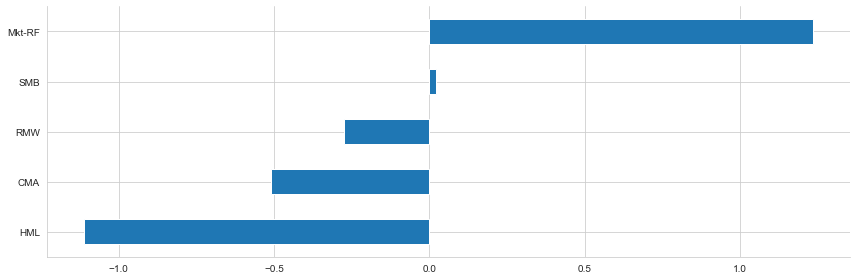

In [21]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [22]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.344320
SMB       0.005152
HML      -0.269338
RMW      -0.090974
CMA      -0.145308
dtype: float64

#### 结果

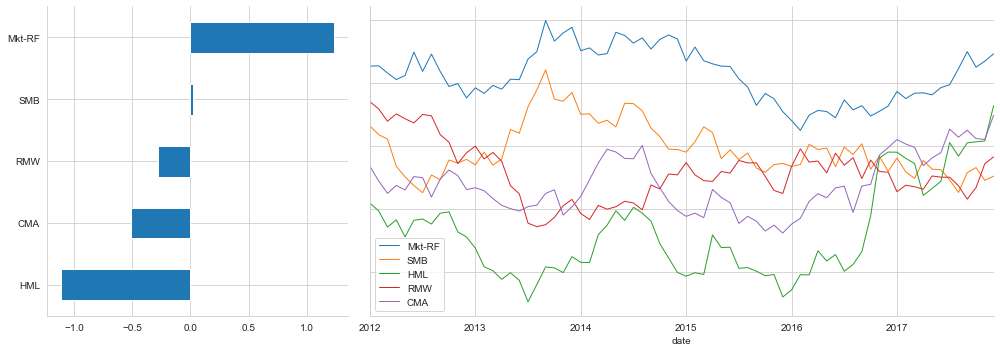

In [23]:
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

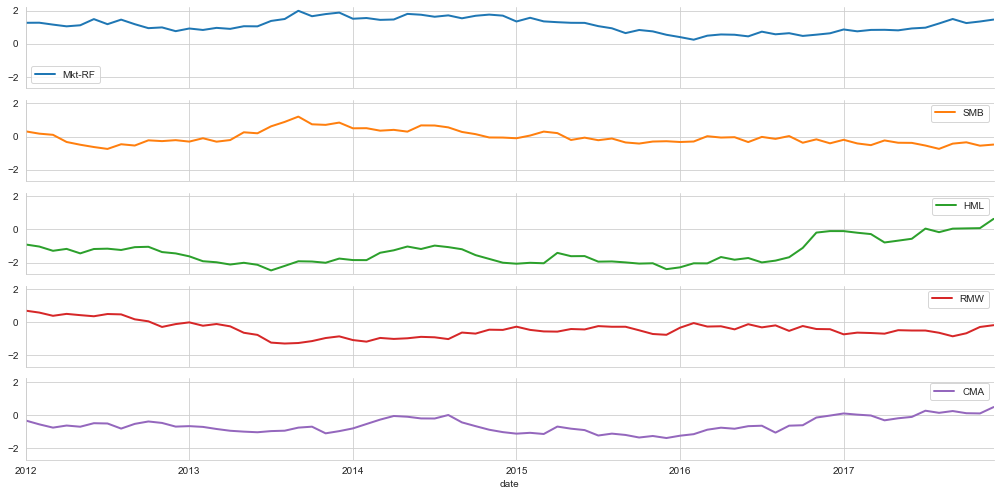

In [24]:
window = 24  # months
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()

## Fama-Macbeth 与 LinearModels 库

Linear_models 库使用面板数据的各种模型扩展了 statsmodels，并且还实现了两阶段 Fama-MacBeth 过程：

In [25]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6879
No. Factors:                          5   J-statistic:                    15.622
No. Observations:                    95   P-value                         0.2091
Date:                  Tue, Jul 11 2023   Distribution:                 chi2(12)
Time:                          20:17:05                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2357     0.4097     3.0158     0.0026      0.4326      2.0388
SMB            0.0202     0.8688    

In [26]:
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6879
No. Factors:                          5   J-statistic:                    15.622
No. Observations:                    95   P-value                         0.2091
Date:                  Tue, Jul 11 2023   Distribution:                 chi2(12)
Time:                          20:17:05                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2357     0.4097     3.0158     0.0026      0.4326      2.0388
SMB            0.0202     0.8688    

这为我们提供了相同的结果：

In [27]:
lambdas.mean()

Mkt-RF    1.235686
SMB       0.020156
HML      -1.113237
RMW      -0.275555
CMA      -0.509358
dtype: float64